## Tutorial 2: P22 Mouse Brain

A `STARNet` workflow can be divided into two stages: STARNet model training and GRN module inference, as well as leveraging the inferred Gene Regulatory Network for downstream tasks (such as Spatial Trajectory Inference and Cell Reprogramming).

In this tutorial, we will show how to prepare the necessary data for STARNet training. The data includes paired RNA_ATAC-seq data for the `mouse brain`. After training, we will utilize the gene and spot embedding for the downstream Gene Regulatory Network(GRN) Inference.

In [2]:
# Loading
import logging
import warnings
logging.getLogger("lightning.pytorch").propagate = False
warnings.simplefilter("ignore", FutureWarning)

import STARNet as ST
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import pickle
# import omicverse as ov

def rotate_points_90_degrees_counterclockwise(points):
    rotated_points = np.array([-points[:, 1], points[:, 0]]).T
    return rotated_points

## Stage 1: Model Training and GRN Inference

### Read data

First, we need to prepare the paired RNA-seq and ATAC-seq for the model training. We load the data from the `h5ad` format, which is a standard format for AnnData storage. For more information, please refer to this documentation[to implement]. Moreover, we need to load an additional `peak2gene file`, which contains the corresponding relationships between specific genes and positions on the chromosome.

The data used for this tutorial, which is the spatial transcriptome for the mouse brain and the peak2gene file, can be downloaded from the following links from Google Drive:

In [3]:
adata_rna = sc.read_h5ad("../GoogleDrive/fig4/Raw_Data/adata_rna.h5ad")
adata_atac = sc.read_h5ad("../GoogleDrive/fig4/Raw_Data/adata_atac.h5ad")
peak2gene_path = "../GoogleDrive/peak2gene.json"

Here, we used `ST.model.STARNet` to construct a `STARNet object` to train the model. We need to specify the `RNA-seq`, `ATAC-seq`, and `peak2gene file paths` during the model initialization.

In [5]:
starnet_obj = ST.model.STARNet(adata_rna, adata_atac, peak2gene_path, device='cuda:7')

Using device: cuda:7


Then, we use the `preprocess()` function to prepare the transcriptomics data and construct graphs. This single function handles multiple tasks: quality control, selection of highly variable genes/peaks, data normalization, and construction of various graphs (scRNA, scATAC, cell neighbor, and peak2gene).

RNA data info:
AnnData object with n_obs × n_vars = 9215 × 22914
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_spatial'
ATAC data info:
View of AnnData object with n_obs × n_vars = 9215 × 278227
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'Sample'
    obsm: 'X_spatial'
Converting adata_rna.X to sparse matrix format.


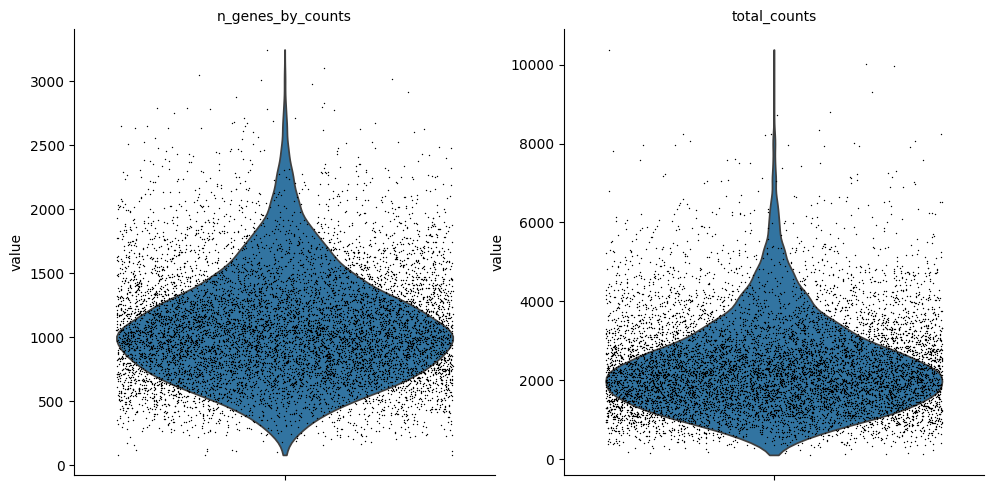

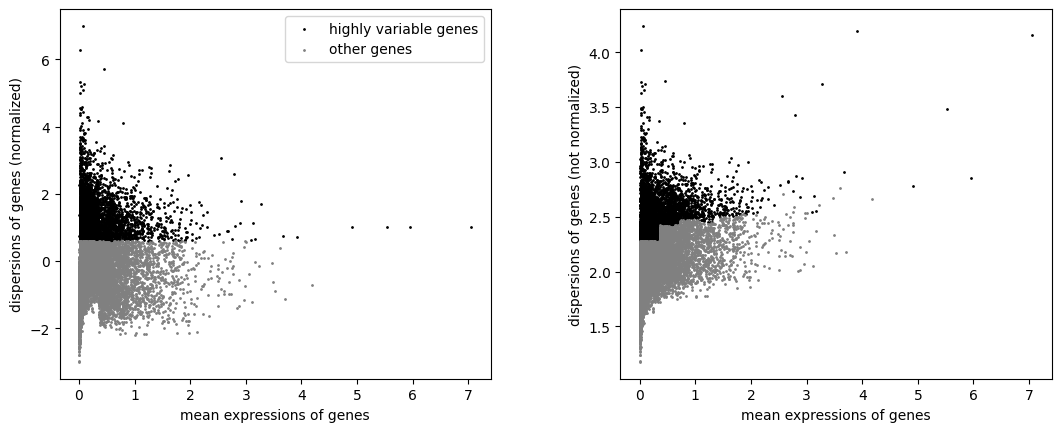

2025-07-08 08:10:28 - INFO - Selected 40000 features.


Graph data moved to device: cuda:7


In [6]:
starnet_obj.preprocess()

Finally, we train the model for 600 epochs, which is the recommended duration. The outputs—cell embedding and gene embedding—are saved to the obs and uns layers of the AnnData.

Lightning model built.
Starting Lightning training...


Training: |          | 0/? [00:00<?, ?it/s]

Moving model to device: cuda:7

 Evaluating at epoch 600
Evaluating clustering using representation 'cell_embedding'...
Plotting clustering results...


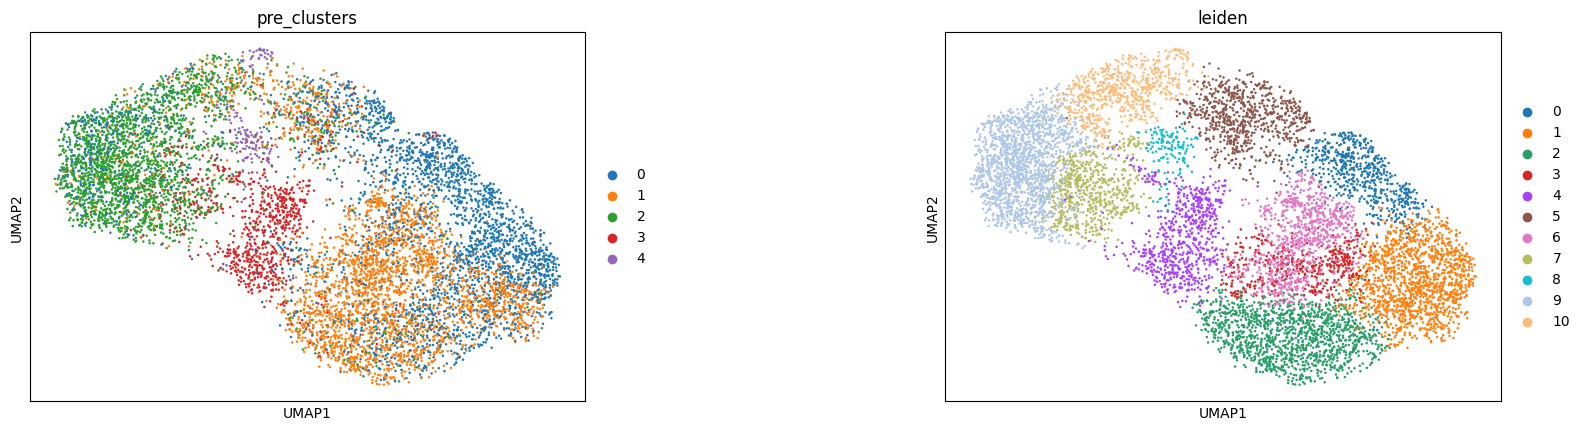

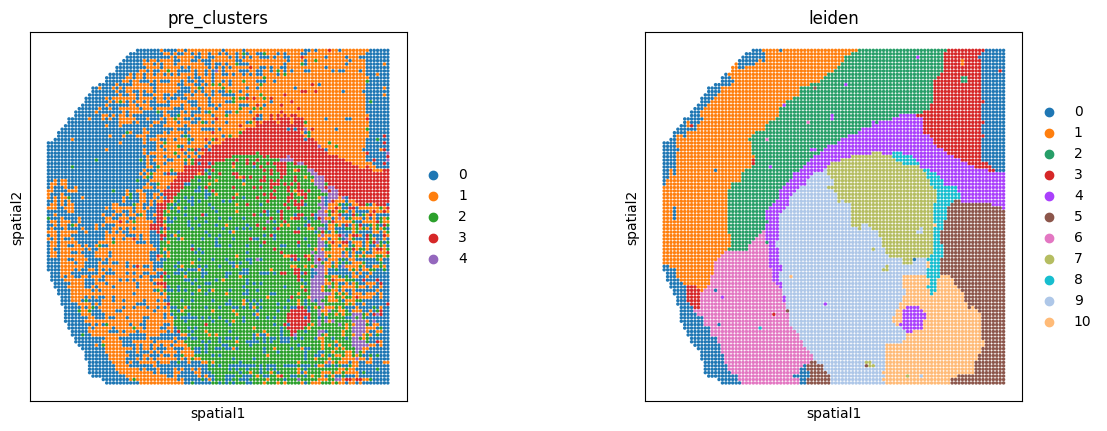

Embeddings saved to adata_rna.obsm['cell_embeddings'] and adata_rna.uns['gene_embeddings']
Training finished!
TensorBoard logs saved to: ./lightning_logs/STARNet/version_17
Checkpoints saved to: ./lightning_logs/checkpoints


In [7]:
starnet_obj.train(epochs=600, eval_every=600)

The AnnData for RNA-seq is shown below. We save it for later usage.

In [8]:
print(f'RNA data after training: {starnet_obj.adata_rna}')
starnet_obj.adata_rna.write_h5ad("../GoogleDrive/fig4/Process_Data/after_training_rna.h5ad")

RNA data after training: AnnData object with n_obs × n_vars = 9215 × 15414
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'pre_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'pre_clusters_colors', 'leiden_colors', 'gene_embedding'
    obsm: 'X_spatial', 'X_pca', 'cell_embedding', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'


### Load multi-omics data

Here we provide two data options for the GRN Inference: one is to directly use the data you trained in stage 1, and the other is to load from your pre-trained dataset.

In [9]:
# Load data from the trained model or from a saved state

# optional
# adata_rna = starnet_obj.adata_rna
# adata_atac = starnet_obj.adata_atac

adata_rna = sc.read_h5ad('../GoogleDrive/fig4/Process_Data/after_training_rna.h5ad')
adata_rna_raw = sc.read_h5ad("../GoogleDrive/fig4/Raw_Data/adata_rna.h5ad")
adata_atac = sc.read_h5ad("../GoogleDrive/fig4/Raw_Data/adata_atac.h5ad")

We continue to process the RNA-ATAC-seq data and add the raw counts into the `count` layer, as the later GRN calculation is based on the raw count data.

RNA data info:
AnnData object with n_obs × n_vars = 9215 × 15414
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'pre_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'gene_embedding', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'pre_clusters_colors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'cell_embedding'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
ATAC data info:
AnnData o

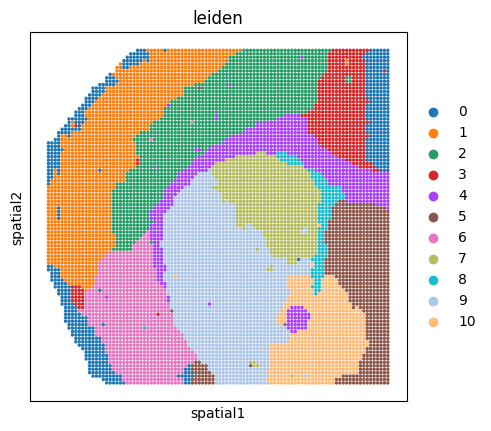

In [11]:
gene_embedding = ad.AnnData(adata_rna.uns['gene_embedding'])
gene_embedding.obs_names = adata_rna.var_names.tolist()
adata_rna.uns['gene_embedding'] = gene_embedding

adata_rna.layers['counts'] = adata_rna_raw[:,adata_rna.var_names].X
adata_atac.layers['counts'] = adata_atac.X

# Preprocess
adata_rna.obs_names = [obs_names.split('-')[0] for obs_names in adata_rna.obs_names]
adata_atac.obs_names = [obs_names.split('-')[0] for obs_names in adata_atac.obs_names]

print(f'RNA data info:\n{adata_rna}')
print(f'ATAC data info:\n{adata_atac}')

sc.pl.spatial(adata_rna,color='leiden',spot_size=1)

### Load Genomic Files and Inference

With all the data properly prepared, we can now load `genomic data` and begin inferring GRN from multiomics data. The `use_rep` parameter specifies which cell embedding to use. The `pvalue_regulatory` parameter filters out genes with significance greater than 0.2, while `moranI_threshold` ensures that only TFs with Moran's I values less than 0.01 are considered spatially specific and used for subsequent analysis.

In [12]:
genomic_data_pathway = '../GoogleDrive/Genomic_data'
adata_rna = ST.grn.infer_grn_from_multiomics(adata_rna,
                                             adata_atac,
                                             genomic_data_pathway,
                                             use_rep='cell_embedding',
                                             pvalue_regulatory=0.2,
                                             moranI_threshold=0.01,
                                             n_jobs=5)

Calculate the GC proportion for all peaks.
Calculate the moran's I index for all TFs.


  0%|          | 0/100 [00:00<?, ?/s]

Perform data format standardization.
Identify the primary GRN based on the spatial co-expression relationship of genes.
Identify 137 candidate transcription factors from spatial specific genes.
Identify candidate target genes using cosine similarity of gene embeddings...


Processing TFs: 100%|██████████| 137/137 [00:00<00:00, 182.08it/s]


Calculate the metacells for spatial RNA-seq and spatial ATAC-seq data by using SEACells.
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/9215 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/9215 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/9215 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on cell_embedding
Computing diffusion components from cell_embedding for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 111 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 21/21 [00:00<00:00, 82.90it/s]


Selecting 11 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.18205
Starting iteration 1.
Completed iteration 1.
Converged after 7 iterations.
Converged after 8 iterations.
Converged after 9 iterations.
Starting iteration 10.
Completed iteration 10.
Converged after 10 iterations.


100%|██████████| 122/122 [00:00<00:00, 184.05it/s]


75.15 % candidate target genes are filtered by using pearson correlation.
Filter candidate target genes by detecting the significant regulatory peaks from the 100000 bp before and after the transcription start site of the target gene.


Processing chromosomes: 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Loading transcripts per gene...
Preparing matrices for gene-peak associations


  0%|          | 0/13746 [00:00<?, ?it/s]/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the con

Computing peak-gene correlations


100%|██████████| 13746/13746 [3:56:53<00:00,  1.03s/it]  


Perform motif scanning.
Identify the motif corresponding to specific transcription factors.


100%|██████████| 137/137 [02:59<00:00,  1.31s/it]


Identify the finally spatial related gene regulatory network.
added the original Peak2Gene to `.uns['Origin_Peak2Gene']`
added the filtered Peak2Gene to `.uns['Peak2Gene']`
added the regulatory_peaks for each TF to `.uns['regulatory_peaks']`
added the spatial-related gene regulatory network to `.uns['grn_df']`


Now, we need to extract the peak-gene association via the `Gene Transfer Format file`, which can be downloaded from the following links: [To be implemented]. This extraction is necessary because transcription factors (TFs) can bind to spatially specific cis-regulatory elements (cCREs) of DNA and activate target gene expression in spatially specific Gene Regulatory Networks (GRNs).

In [13]:
gtf_pathway = '../GoogleDrive/Reference/gencode_vM25.chr_patch_hapl_scaff.annotation.gtf.gz'
peak2gene = ST.pp.extract_peak_gene_associations(adata_rna,gtf_file=gtf_pathway)
peak2gene.to_csv('model_out/peak2gene.links', sep="\t", index=False)

Extracting peak-to-gene associations...


Processing genes: 100%|██████████| 13746/13746 [01:57<00:00, 117.47it/s]


Found 146585 peak-gene associations. Processing coordinates...
Adding genomic coordinates for 13452 unique genes...


Adding gene coordinates: 100%|██████████| 13452/13452 [00:45<00:00, 295.34it/s]


Calculating association scores...
Filtering self-associations...
Completed processing. Returned 146465 peak-gene associations.


After obtaining the GRN and peak-gene links information, we can score each GRN and TF module to quantify the strength of a TF's influence on its target genes. This regulatory score serves two primary purposes. First, it enables clear GRN visualization by filtering for the most significant interactions. Second, in cell reprogramming analysis, these scores function as edge weights in the constructed GRN, which is then provided as a key input to the PriciCE model.

In [14]:
# Perform permutation test on all gene regulatory networks
adata_rna = ST.pp.score_all_grn(adata_rna,n_jobs=5)

# Calculate the TF module using various clustering methods and perform cauchy combination tests
adata_rna = ST.pp.score_TF_module(adata_rna,
                                  clustering_method='mclust',
                                  n_components=30,
                                  groupby='leiden',n_jobs=5)

# Calculate the TF module using various clustering methods and perform cauchy combination tests
adata_rna = ST.pp.score_TF_module(adata_rna,
                                  clustering_method='leiden',
                                  resolution = 2,
                                  groupby='leiden',n_jobs=5)

Computing the significance of gene regulatory network with permutation test.


100%|██████████| 136/136 [17:04<00:00,  7.53s/it]
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


added the p-values of GRN to `.uns['grn']['pval']`
added the -log10 p-values of GRN to `.uns['grn']['nlog10_pval']`
added the -log10 p-values for all GRNs to `.uns['grn']['adata_nlog10_pval']`.
Start to perform TF clustering.
running GaussianMixture clustering
finished: found 30 clusters and added 'mclust', the cluster labels (adata.obs, categorical)
Start to score TF modules.


 33%|███▎      | 10/30 [00:50<01:41,  5.10s/it]/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set t

added the p-values of the TF modules to `.uns['TF_module']['pval']`
added the -log10 p-values of the TF modules to `.uns['TF_module']['nlog10_pval']`
added the TF genes of the TF modules to `.uns['TF_module']['TF_list']`
added the target genes of the TF modules to `.uns['TF_module']['target_gene_list']`
Start to perform cauchy combination tests for TF modules.
added the p-values of cauchy_combination_test for the TF modules to `.uns['cauchy_combination_test']`
Start to perform TF clustering.
Start to score TF modules.


100%|██████████| 12/12 [00:52<00:00,  4.41s/it]


added the p-values of the TF modules to `.uns['TF_module']['pval']`
added the -log10 p-values of the TF modules to `.uns['TF_module']['nlog10_pval']`
added the TF genes of the TF modules to `.uns['TF_module']['TF_list']`
added the target genes of the TF modules to `.uns['TF_module']['target_gene_list']`
Start to perform cauchy combination tests for TF modules.
added the p-values of cauchy_combination_test for the TF modules to `.uns['cauchy_combination_test']`


We can save the calculated and scored GRN and TF modules in `AnnData` and `pickle` formats, respectively, for later downstream analysis.

In [15]:
adata_rna.uns['grn']['adata_nlog10_pval'].T.write_h5ad("model_out/fig6_grn_nlog10_pval.adata")

with open('model_out/TF_module_30.pkl', 'wb') as f:
	pickle.dump(adata_rna.uns['TF_module'], f)

with open('model_out/TF_module_leiden_2.pkl', 'wb') as f:
	pickle.dump(adata_rna.uns['TF_module'], f)

### Visualization of GRN modules

The following cell visualizes the GRN module in spatial coordinates, which aligns well with specific areas of the mouse brain.

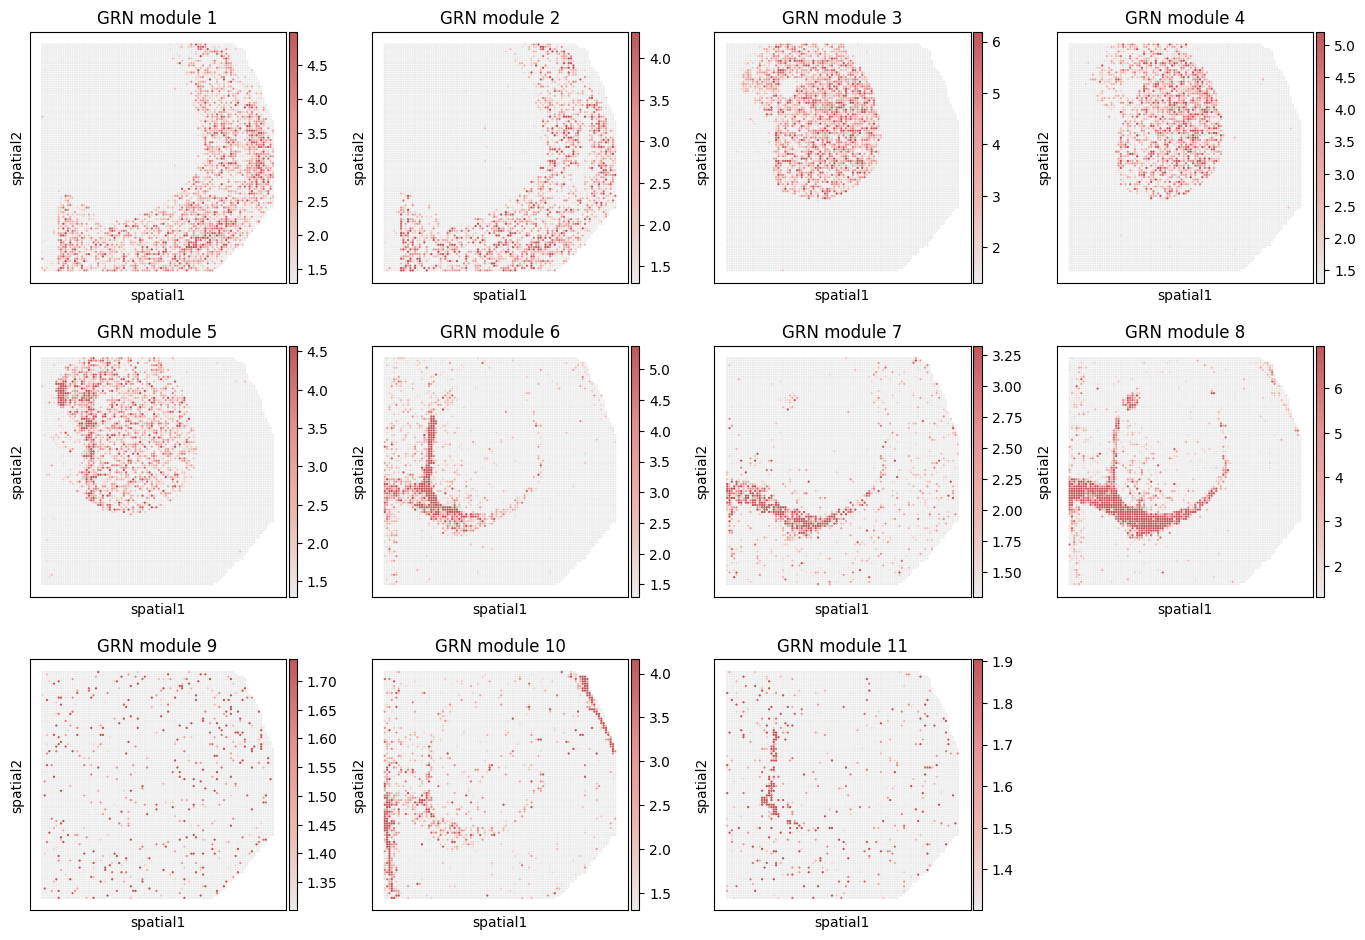

In [16]:
nlog10_pval_df = adata_rna.uns['TF_module']['nlog10_pval_df']
nlog10_pval_df = nlog10_pval_df.loc[:,[str(i) for i in range(11)]]
nlog10_pval_ad = ad.AnnData(nlog10_pval_df)
nlog10_pval_ad.obsm['spatial'] = adata_rna[nlog10_pval_ad.obs_names,:].obsm['spatial']
nlog10_pval_ad.obsm['spatial'] = rotate_points_90_degrees_counterclockwise(nlog10_pval_ad.obsm['spatial'])
nlog10_pval_ad.obsm['spatial'] = rotate_points_90_degrees_counterclockwise(nlog10_pval_ad.obsm['spatial'])
nlog10_pval_ad.var_names = ['GRN module ' + str(int(GRM)+1) for GRM in nlog10_pval_ad.var_names]

def get_cmap_seg(colors,N=256):
        from matplotlib.colors import LinearSegmentedColormap
        # Define the colors for the gradient
        colors = np.array(colors) / 255.0
        # Create a colormap from the list of colors
        cmap_name = 'custom_cmap'
        cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=N)
        return cmap

colors = [(236, 236, 236), (237, 184, 176), (230, 145, 145), (194, 87, 89)]

with plt.rc_context({"figure.figsize": (3.5,3.5)}):
    sc.pl.spatial(nlog10_pval_ad,
                  color=nlog10_pval_ad.var_names,
               #  colorbar_loc=None,
               #  frameon=False,
                  cmap=get_cmap_seg(colors),
                  legend_loc=None,
                  spot_size=1,
                  vmax='p98',
                  vmin=-np.log10(0.05),
                  outline_width= (0.3, 0.5),
                  ncols=4,
                  hspace=0.25,
                  wspace=0.18,
                  show=False,)
